# Experiments in the Section 4.3 (Applications to Anomaly Detection).

### Here you just have to run the entire notebook. It may takes approximatively 30 minutes.

In [1]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import pandas as pd
from multiprocessing import Pool
from functools import partial
from itertools import combinations
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import csv
import pywt
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")
import FCHD
import FIF # Functional isolation Forest algorithm
import os
from sklearn.metrics import auc, roc_curve, roc_auc_score

# Normal datasets:

In [2]:
X = pd.read_csv('Dataset_brownian_geom.csv', header=None)
X = X.as_matrix()
X = X[:100]
Y = pd.read_csv('Dataset_deux.csv', header=None)
Y = Y.as_matrix()
Y = Y[:100]
times = np.linspace(0,1, X.shape[1])

### Functional Stahel-Donoho-Outlyingness and Functional Tukey depth

In [3]:
def functional_Stahel_Donoho(X_train, X_test):
    m = X_train.shape[1]
    n1 = X_train.shape[0]
    n2 = X_test.shape[0]
    S = np.zeros((n2,m))
    for t in range(m):
        for i in range(n2):
            S[i,t] = np.abs(X_test[i,t] - np.median(X_train[:,t]))
        if (np.median(np.abs(X_train[:,t]-np.median(X_train[:,t]))) > 0):
            S[:,t] = 1 / (1 + S[:,t] / np.median(np.abs(X_train[:,t]-np.median(X_train[:,t]))))
    
    return  np.mean(S, axis=1) 

In [4]:
def functional_Tukey(X_train, X_test):
    m = X_train.shape[1]
    n1 = X_train.shape[0]
    n2 = X_test.shape[0]
    S = np.zeros((n2,m))
    Z = np.zeros(n1)
    for t in range(m):
        for i in range(n2):
            Z = X_train[:,t] - X_test[i, t]
            S[i, t] = np.sum(1* (Z >0))
        S[:, t] = S[:, t]  / n1
        S[:, t]  = np.minimum(S[:, t] , 1 - S[:, t]  )
    return np.mean(S, axis=1)

# Construction of anomalies:

## Location anomalies:

In [5]:
def Location_anomalies(X, param, data=1):
    np.random.seed(42)
    subsample = np.random.choice(np.arange(100), 15)
    Z = np.copy(X)
    Proportion_anom_detected = np.zeros((20,4))
    k=0
    for par in param:
        if (data == 1):
            Z[subsample] = X[subsample] + X[subsample] * par
        else:
            Z[subsample] = X[subsample] +  par

        FCHD0 = FCHD.FuncCHD(Z,times, Subsampling=True, J=3)
        S1 = FCHD0.compute_depth(Z)  
        S2 = functional_Stahel_Donoho(Z, Z)
        S3 = functional_Tukey(Z, Z)
        FIF0 = FIF.FIForest(Z, time=times, innerproduct='auto', D='cosinus')
        S4 = 1 - FIF0.compute_paths()


        Proportion_anom_detected[k ,0] = np.sum( 1.* (S1[subsample] < np.quantile(S1, 0.15)))
        Proportion_anom_detected[k ,1] = np.sum( 1.* (S2[subsample] < np.quantile(S2, 0.15)))
        Proportion_anom_detected[k ,2] = np.sum( 1.* (S3[subsample] < np.quantile(S3, 0.15)))
        Proportion_anom_detected[k ,3] = np.sum( 1.* (S4[subsample] < np.quantile(S4, 0.15)))
        k += 1

    return Proportion_anom_detected

In [6]:
param1 = np.linspace(0,3,20)
A1 = Location_anomalies(X, param1)

## Isolated anomalies:

In [7]:
def Isolated_anomalies(X, param, data=1):
    np.random.seed(42)
    subsample = np.random.choice(np.arange(100), 15)
    t = np.random.choice(np.arange(40), len(subsample))
    Z = np.copy(X)
    Proportion_anom_detected = np.zeros((20,4))
    k=0
    for par in param:
        if (data == 1):
            Z[subsample, t] = X[subsample, t] + X[subsample, t] * par
        else:
            Z[subsample, t] = X[subsample, t] +  par
            
        FCHD0 = FCHD.FuncCHD(Z,times, Subsampling=True, J=3)
        S1 = FCHD0.compute_depth(Z)  
        S2 = functional_Stahel_Donoho(Z, Z)
        S3 = functional_Tukey(Z, Z)
        FIF0 = FIF.FIForest(Z, time=times, innerproduct='auto', D='gaussian_wavelets')
        S4 = 1 - FIF0.compute_paths()


        Proportion_anom_detected[k ,0] = np.sum( 1.* (S1[subsample] < np.quantile(S1, 0.15)))
        Proportion_anom_detected[k ,1] = np.sum( 1.* (S2[subsample] < np.quantile(S2, 0.15)))
        Proportion_anom_detected[k ,2] = np.sum( 1.* (S3[subsample] < np.quantile(S3, 0.15)))
        Proportion_anom_detected[k ,3] = np.sum( 1.* (S4[subsample] < np.quantile(S4, 0.15)))
        k += 1
        
    return Proportion_anom_detected

In [8]:
param1 = np.linspace(0,10,20)
A2 = Isolated_anomalies(X, param1)

## Shape anomalies:

In [9]:
np.random.seed(42)
k=0
Z = Y.copy()
param = np.linspace(1,2,20)
B = np.zeros((15,40))
Proportion_anom_detected = np.zeros((20,4))
for f in param:
    Z = Y.copy()
    Z[85:] = Z[85:] * f
    
    
    
    
    FCHD0 = FCHD.FuncCHD(Z,times, Subsampling=True,  J=2)
    S1 = FCHD0.compute_depth(Z)  
    S2 = functional_Stahel_Donoho(Z, Z)
    S3 = functional_Tukey(Z, Z)
    FIF0 = FIF.FIForest(Z, time=times, innerproduct='auto', D='cosinus', alpha=1)
    S4 = 1 - FIF0.compute_paths()


    Proportion_anom_detected[k ,0] = np.sum( 1.* (S1[85:] < np.quantile(S1, 0.15)))
    Proportion_anom_detected[k ,1] = np.sum( 1.* (S2[85:] < np.quantile(S2, 0.15)))
    Proportion_anom_detected[k ,2] = np.sum( 1.* (S3[85:] < np.quantile(S3, 0.15)))
    Proportion_anom_detected[k ,3] = np.sum( 1.* (S4[85:] < np.quantile(S4, 0.15)))
    k += 1



Text(0.5, 0, 'e')

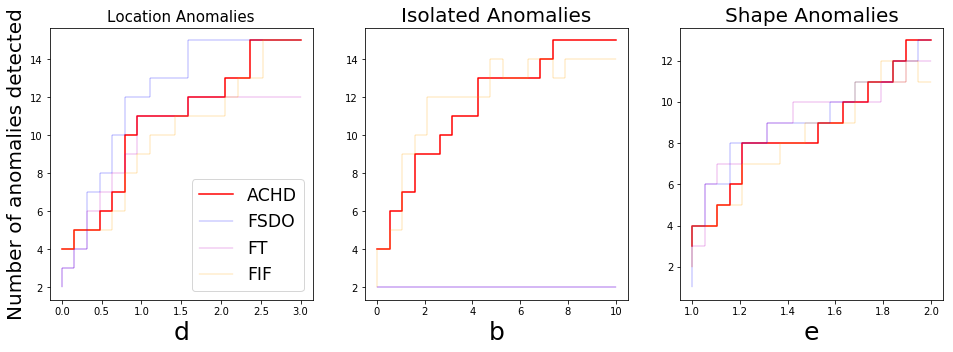

In [10]:
# Location anomalies:
plt.figure(figsize=(16,5))
plt.subplot(131)
plt.title('Location Anomalies', size=15)
plt.step(np.linspace(0,3,20), A1[:,0], label = 'ACHD', c='r')
plt.step(np.linspace(0,3,20), A1[:,1], label = 'FSDO', c='b', linewidth=0.3)
plt.step(np.linspace(0,3,20), A1[:,2], label = 'FT', c='m', linewidth=0.3)
plt.step(np.linspace(0,3,20), A1[:,3], label = 'FIF', c='orange', linewidth=0.3)
plt.legend(fontsize='xx-large')
plt.ylabel('Number of anomalies detected', size=20)
plt.xlabel('d', size=25)

plt.subplot(132)
plt.title('Isolated Anomalies', size=20)
plt.step(np.linspace(0,10,20), A2[:,0], label = 'ACHD', c='r')
plt.step(np.linspace(0,10,20), A2[:,1], label = 'FSDO', c='b', linewidth=0.3)
plt.step(np.linspace(0,10,20), A2[:,2], label = 'FT', c='m', linewidth=0.3)
plt.step(np.linspace(0,10,20), A2[:,3], label = 'FIF', c='orange', linewidth=0.3)
plt.xlabel('b', size=25)

plt.subplot(133)
plt.title('Shape Anomalies', size=20)
plt.step(np.linspace(1,2,20), Proportion_anom_detected[:,0], label = 'ACHD', c='r')
plt.step(np.linspace(1,2,20), Proportion_anom_detected[:,1],label = 'FSDO', c='b', linewidth=0.3)
plt.step(np.linspace(1,2,20), Proportion_anom_detected[:,2], label = 'FT', c='m', linewidth=0.3)
plt.step(np.linspace(1,2,20), Proportion_anom_detected[:,3], label = 'FIF', c='orange', linewidth=0.3)
plt.xlabel('e', size=25)

#plt.savefig('xp_anomaly.pdf')

# Anomaly detection on Real-world datasets:

In [11]:
Z1 = pd.read_csv('octane.csv')
Z1 = Z1.as_matrix()
Z1 = Z1[:,1:]
Z1 = np.transpose(Z1)
anom1 = np.where(Z1[:,200] >0.15)[0]
z1 = np.zeros(Z1.shape[0]) + 1
z1[anom1] = -1

Z2 = pd.read_csv('wine.csv')
Z2 = Z2.as_matrix()
Z2 = Z2[:,1:]
Z2 = np.transpose(Z2)
anom2 = 36
z2 = np.zeros(Z2.shape[0]) + 1
z2[anom2] = -1

EOGHorizontal = pd.read_csv('EOGHorizontal_Train.csv', header = None)
EOGHorizontal2  = pd.read_csv('EOGHorizontal_Test.csv', header = None)

Z3_train = np.array(EOGHorizontal , dtype = float)[:,1:]
Z3_test = np.array(EOGHorizontal2 , dtype = float)[:,1:]
z3_train = np.array(EOGHorizontal , dtype=float)[:,0]
z3_test = np.array(EOGHorizontal2 , dtype=float)[:,0]


Z3 = np.concatenate((Z3_train,Z3_test), axis=0)
z3 = np.concatenate((z3_train,z3_test))

anom3 = np.where(z3 == -1)[0]

In [12]:
def FPCA_IF_OCSVM(X):
    A_raw = pywt.wavedec(np.array(X),
                     'haar',
                     mode="sym")
    A = np.hstack(A_raw)
    K = 10
    X_tilde = 1. / np.sqrt(X.shape[0]) * A
    my_pca = PCA(n_components = K,
                 whiten = True # For having projections with unit variance
                )
    X_fpca = my_pca.fit_transform(X_tilde) # Matrix of coefficients
    
    IF = IsolationForest(n_estimators=100, max_samples='auto',behaviour='new', contamination='auto')
    IF.fit(X_fpca)
    predict_IF = IF.decision_function(X_fpca)

    OC = OneClassSVM(kernel='rbf',gamma='scale')
    OC.fit(X_fpca)
    predict_OCSVM = OC.decision_function(X_fpca)
    return predict_IF, predict_OCSVM

#### Octane dataset: 6 shape anomalies.

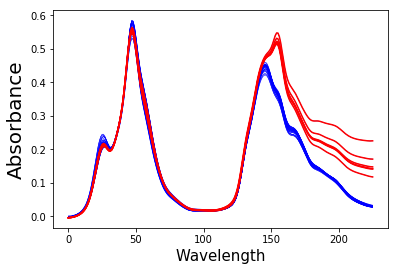

In [13]:
for i in range(Z1.shape[0]):
    plt.plot(Z1[i], c='b', linewidth=0.5)
for j in anom1:
    plt.plot(Z1[j], c='red')
plt.ylabel('Absorbance', size=20)
plt.xlabel('Wavelength', size=15)
plt.show()

#### Wine dataset: only one isolated anomaly.

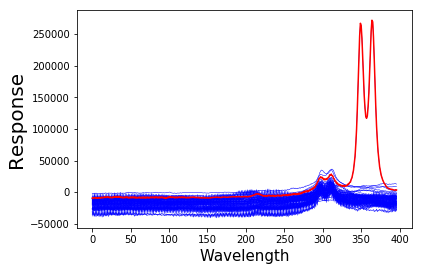

In [14]:
for i in range(Z2.shape[0]):
    plt.plot(Z2[i], c='b', linewidth=0.5)
plt.plot(Z2[36], c='r')
plt.ylabel('Response', size=20)
plt.xlabel('Wavelength', size=15)
plt.show()

#### EOG dataset: various anomalies.

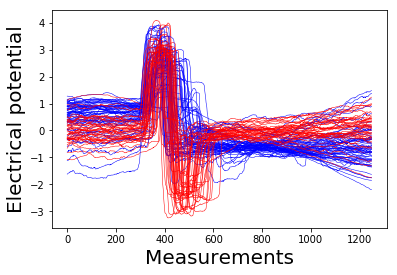

In [15]:
for i in range(Z3.shape[0]):
    if (z3[i] == 1):
        plt.plot(Z3[i], c='b', linewidth=0.5)
    else:
        plt.plot(Z3[i], c='r', linewidth=0.5)
plt.ylabel('Electrical potential', size=20)
plt.xlabel('Measurements', size=20)
plt.show()

In [16]:
np.random.seed(42)
times = np.linspace(0,1,Z1.shape[1])
FCHD0 = FCHD.FuncCHD(Z1,times, Subsampling=True,  J=2)
S1 = FCHD0.compute_depth()
S2 = functional_Stahel_Donoho(Z1,Z1)
S3 = functional_Tukey(Z1,Z1)
FIF0 = FIF.FIForest(Z1, time=times,  innerproduct='auto', D='gaussian_wavelets', alpha=0.5)
S4 = 1 - FIF0.compute_paths()
S5, S6 = FPCA_IF_OCSVM(Z1)




anom_detected = np.zeros(6)
anom_detected[0] = np.sum( 1.* (S1[anom1] < np.quantile(S1, 0.15)))
anom_detected[1] = np.sum( 1.* (S2[anom1] < np.quantile(S2, 0.15)))
anom_detected[2] = np.sum( 1.* (S3[anom1] < np.quantile(S3, 0.15)))
anom_detected[3] = np.sum( 1.* (S4[anom1] < np.quantile(S4, 0.15)))
anom_detected[4] = np.sum( 1.* (S5[anom1] < np.quantile(S5, 0.15)))        
anom_detected[5] = np.sum( 1.* (S6[anom1] < np.quantile(S6, 0.15)))                                             

In [17]:
np.random.seed(42)
anom = 36
times = np.linspace(0,1,Z2.shape[1])
FCHD0 = FCHD.FuncCHD(Z2,times, Subsampling=True,  J=2)
S11 = FCHD0.compute_depth()
S22 = functional_Stahel_Donoho(Z2,Z2)
S33 = functional_Tukey(Z2,Z2)
FIF0 = FIF.FIForest(Z2, time=times, innerproduct='auto', D='gaussian_wavelets', alpha=1)
S44 = 1 - FIF0.compute_paths()
S55, S66 = FPCA_IF_OCSVM(Z2)


anom_detected2 = np.zeros(6)
anom_detected2[0] = np.sum( 1.* (S11[anom2] < np.quantile(S11, 0.025)))
anom_detected2[1] = np.sum( 1.* (S22[anom2] < np.quantile(S22, 0.025)))
anom_detected2[2] = np.sum( 1.* (S33[anom2] < np.quantile(S33, 0.025)))
anom_detected2[3] = np.sum( 1.* (S44[anom2] < np.quantile(S44, 0.025)))
anom_detected2[4] = np.sum( 1.* (S55[anom2] < np.quantile(S55, 0.025)))
anom_detected2[5] = np.sum( 1.* (S66[anom2] < np.quantile(S66, 0.025)))
        

In [18]:
np.random.seed(42)
times = np.linspace(0,1,Z3.shape[1])
FCHD0 = FCHD.FuncCHD(Z3,times, Subsampling=True,  J=2)
S111 = FCHD0.compute_depth()
S222 = functional_Stahel_Donoho(Z3,Z3)
S333 = functional_Tukey(Z3,Z3)
FIF0 = FIF.FIForest(Z3, time=times, innerproduct='auto', D='gaussian_wavelets', alpha=1)
S444 = 1 - FIF0.compute_paths()
S555, S666 = FPCA_IF_OCSVM(Z3)


anom_detected3 = np.zeros(6)
anom_detected3[0] = np.sum( 1.* (S111[anom3] < np.quantile(S111, 0.39)))
anom_detected3[1] = np.sum( 1.* (S222[anom3] < np.quantile(S222, 0.39)))
anom_detected3[2] = np.sum( 1.* (S333[anom3] < np.quantile(S333, 0.39)))
anom_detected3[3] = np.sum( 1.* (S444[anom3] < np.quantile(S444, 0.39)))
anom_detected3[4] = np.sum( 1.* (S555[anom3] < np.quantile(S555, 0.39)))
anom_detected3[5] = np.sum( 1.* (S666[anom3] < np.quantile(S666, 0.39)))

        

In [19]:
print(anom_detected / 6)
print(anom_detected2 / 1)
print(anom_detected3 / 40)

[1.         0.5        0.33333333 1.         0.5        0.5       ]
[1. 0. 0. 1. 0. 1.]
[0.725 0.55  0.475 0.425 0.625 0.6  ]
